Customer Churn by Ben Ilacqua

First we import all of the necessary libraries.

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sea
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_auc_score, roc_curve, recall_score
from sklearn.svm import SVC

Next we import the dataset and get the description and visualization of the data.

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

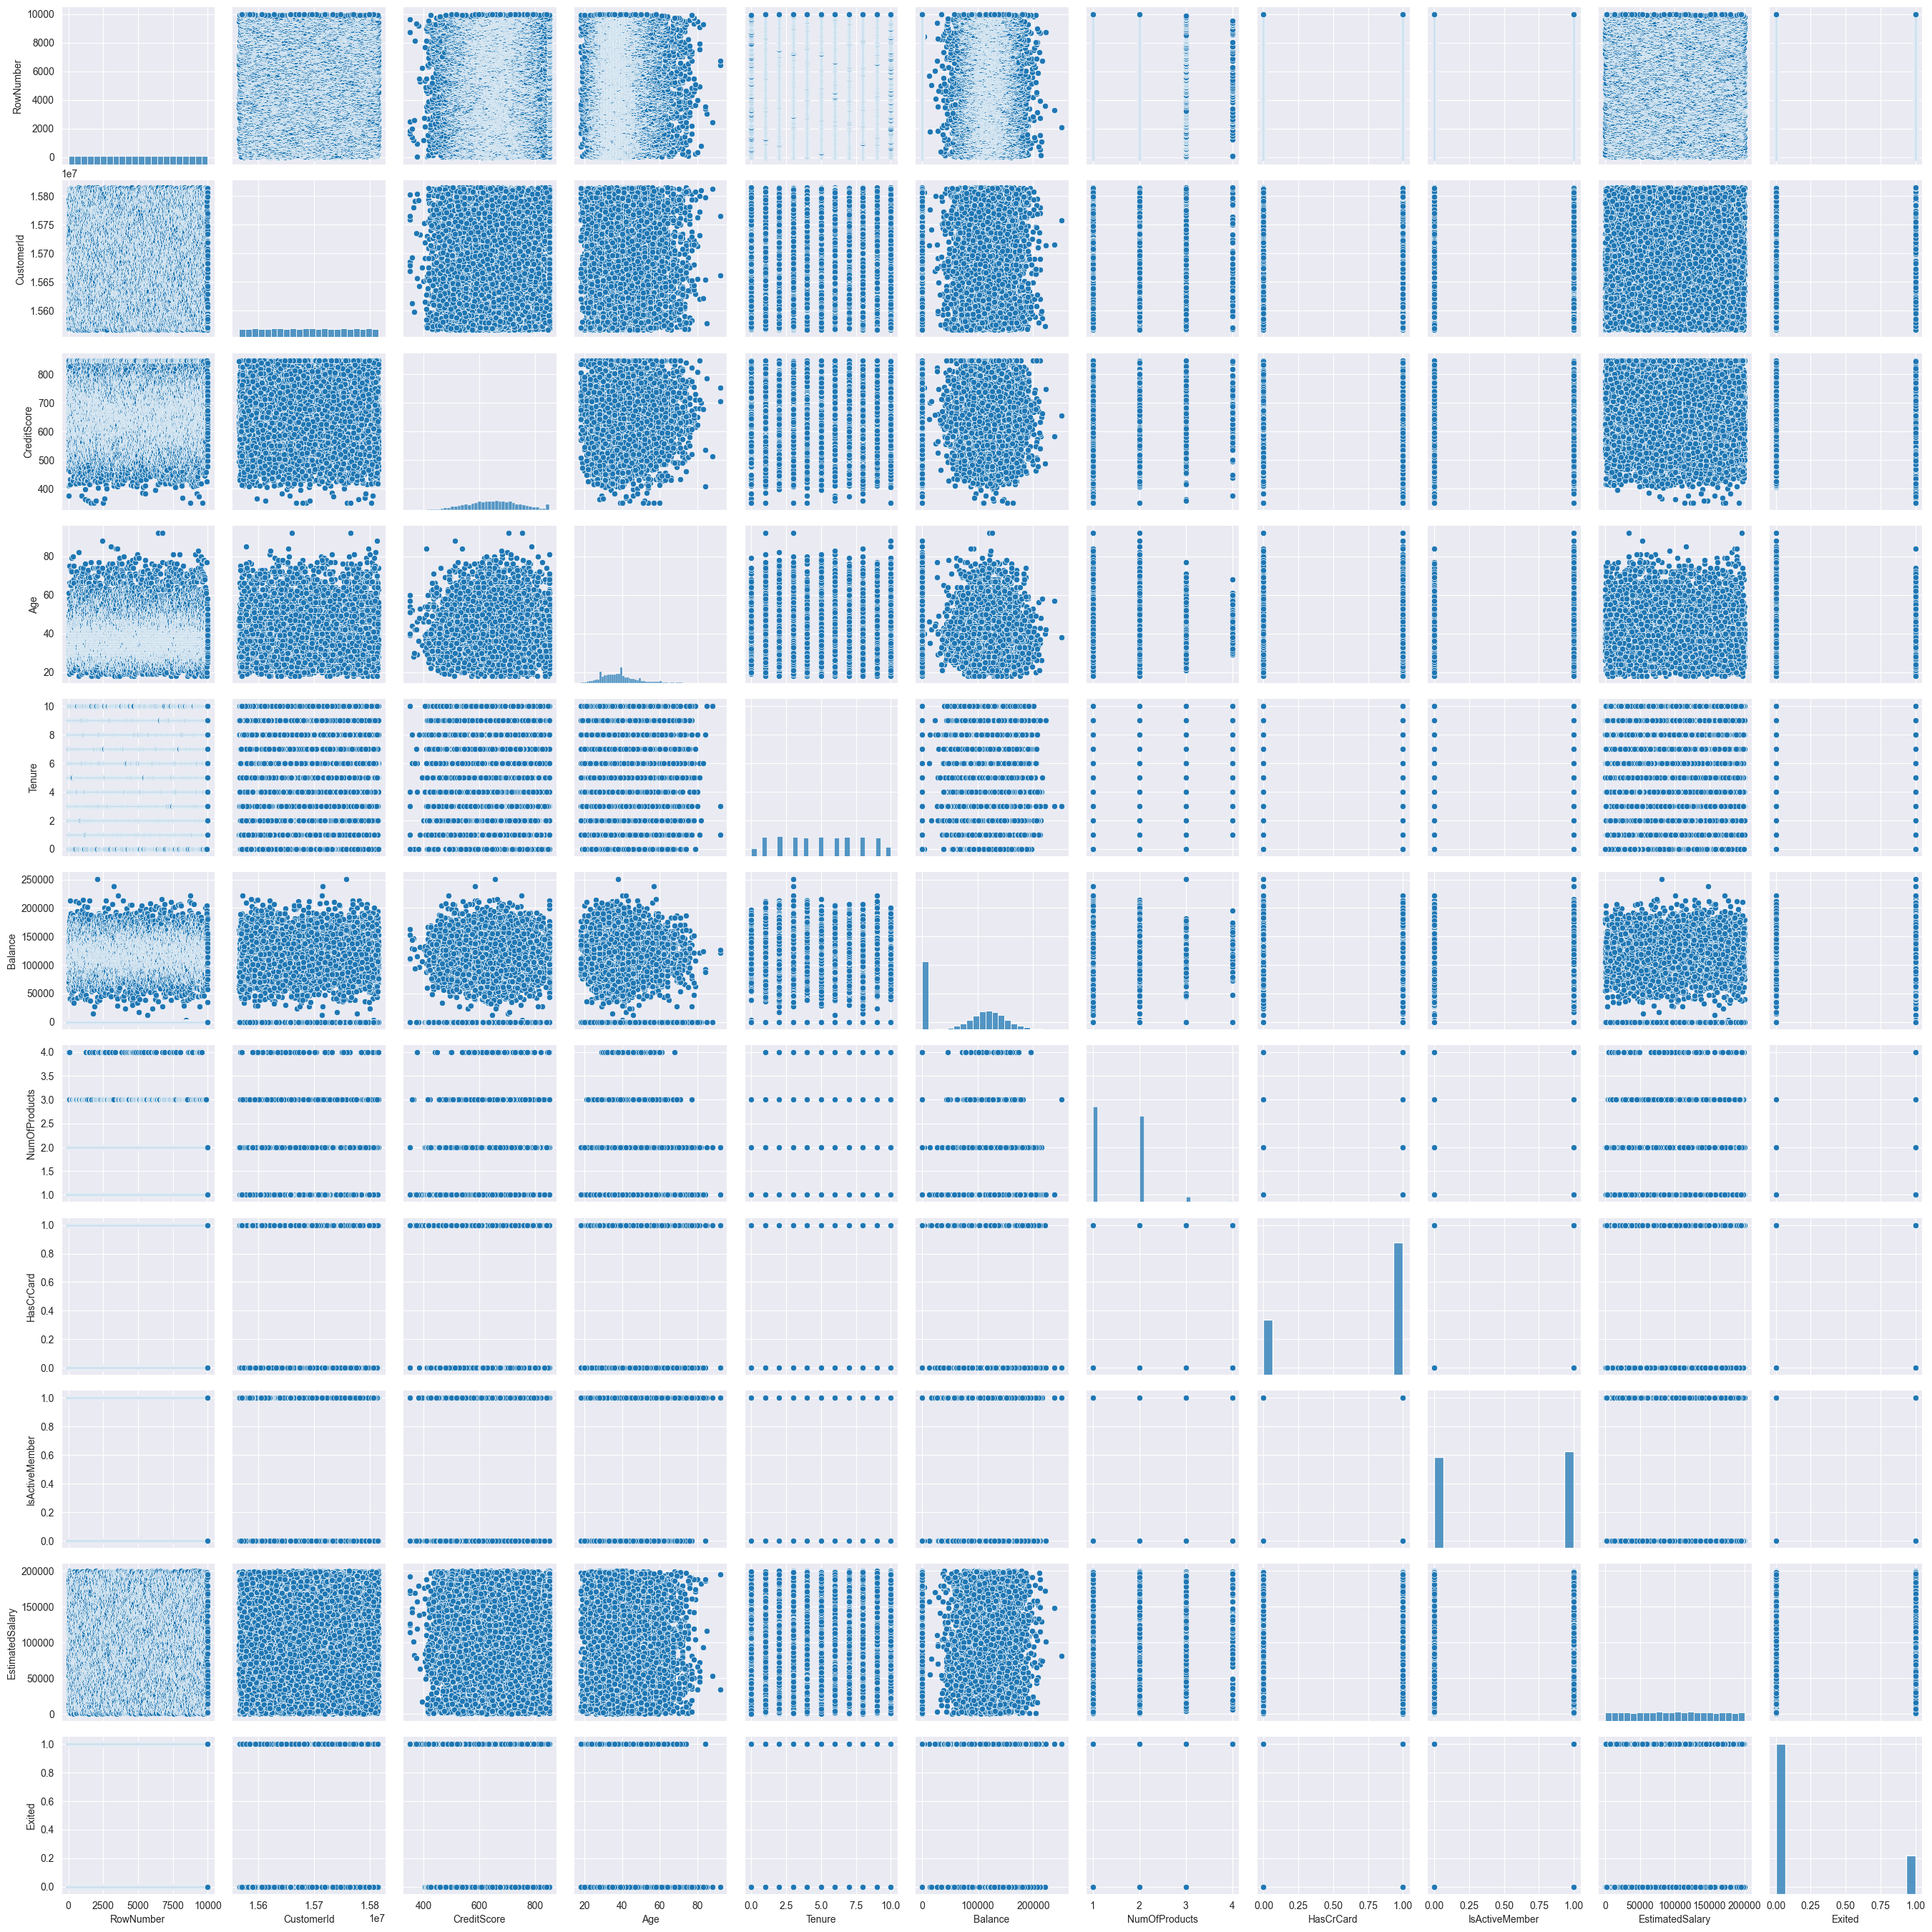

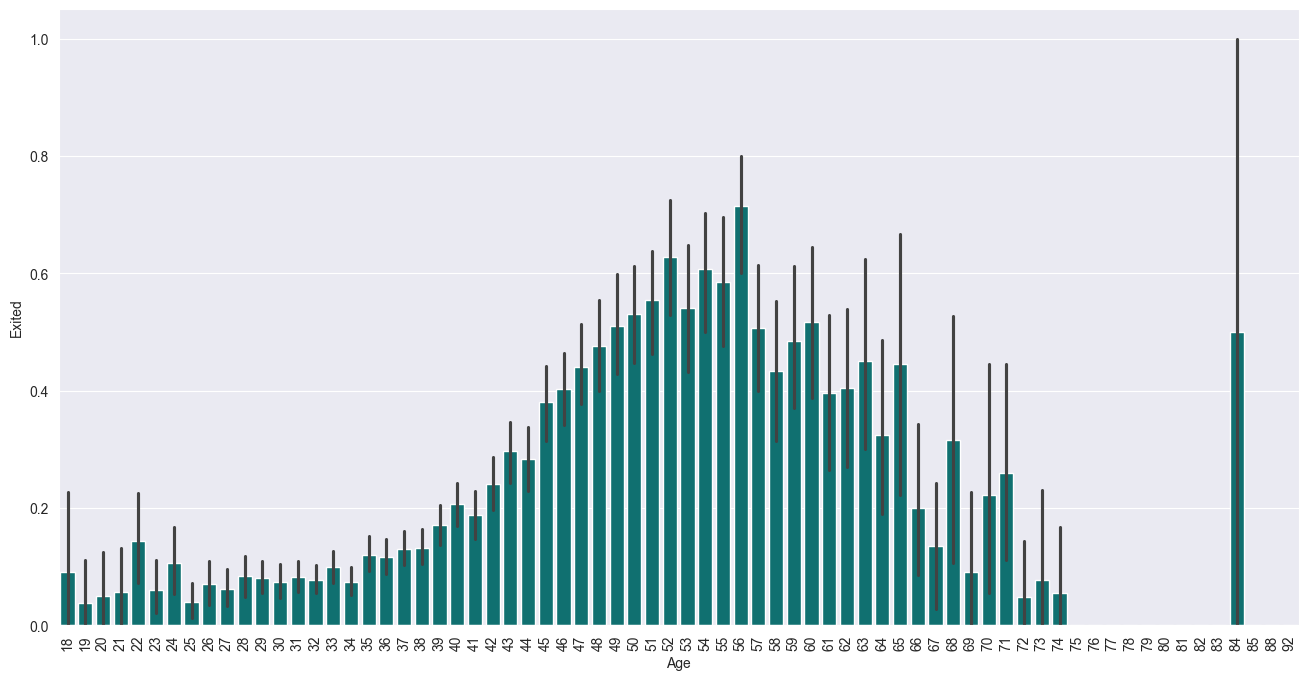

In [14]:
#Reading the dataset into python.
df = pd.read_csv("C:\\Users\\benil\\Downloads\\Customer+churn+files\\Notebook\\Churn Modeling.csv")
print(df.head())

#Checking for any null values to remove.
print(df.isna().sum())
#Getting the counts of customers that exited and stayed.
df['Exited'].value_counts()
#This function gives the descriptive statistics for my dataset.
df.describe()
#This function gives us the number of unique values in each column.
df.nunique()

#The start of data visualization with a pair scatter plot
sea.pairplot(data=df)

#A plot to show how age and exit correlation
plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
sea.barplot(x='Age',y='Exited',color='teal',data=df)


df =df.drop(columns=['RowNumber','CustomerId','Surname'])

We then create a label encoder to relabel our categorical variables and continue with data visualization after dropping three fruitless variables.

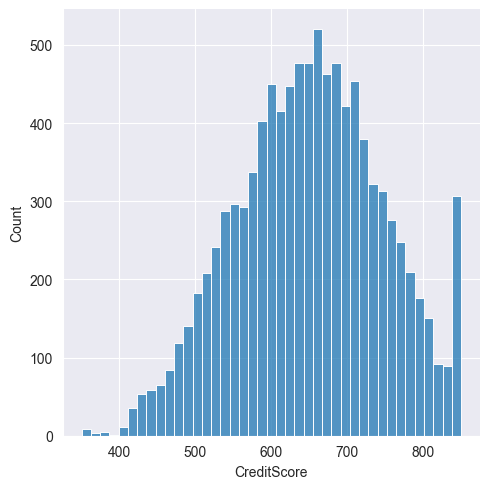

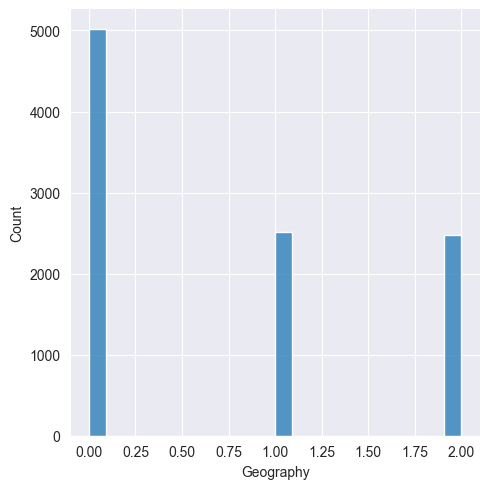

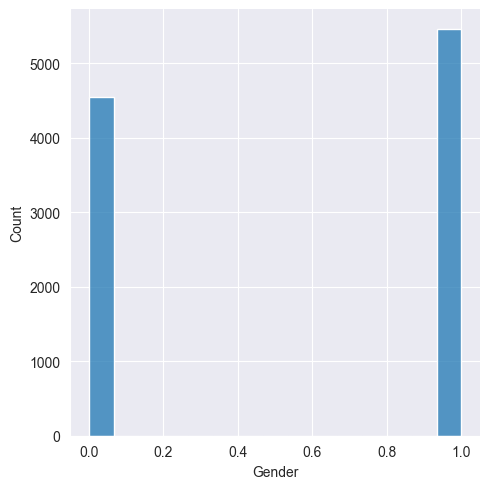

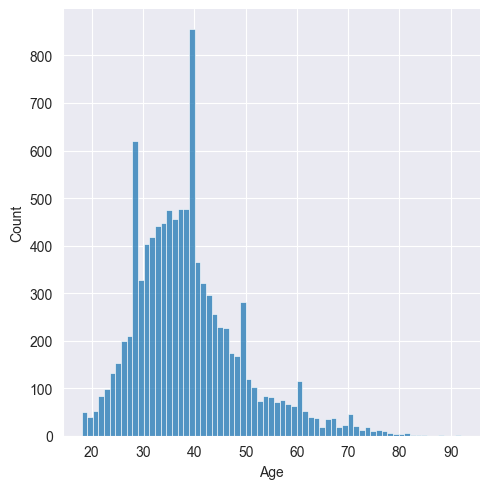

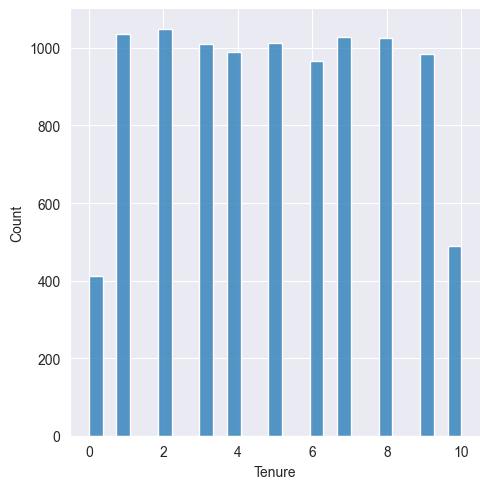

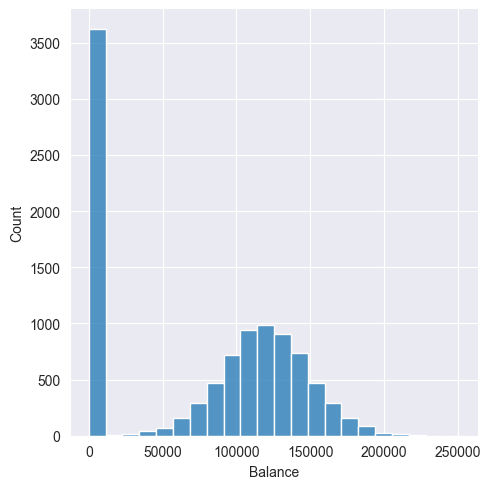

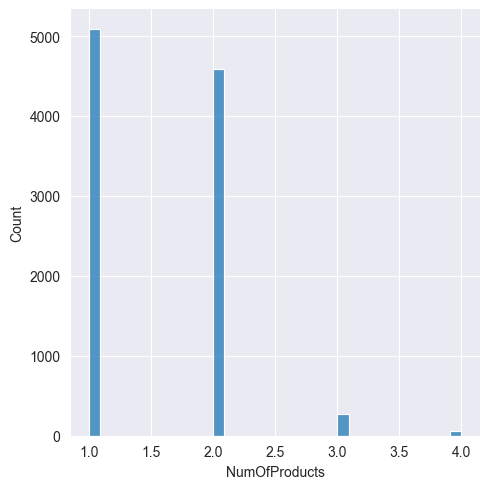

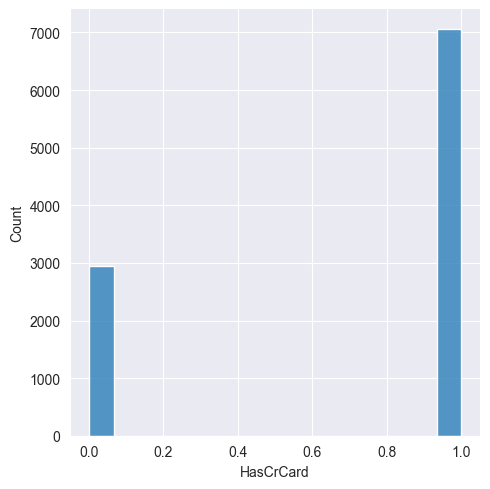

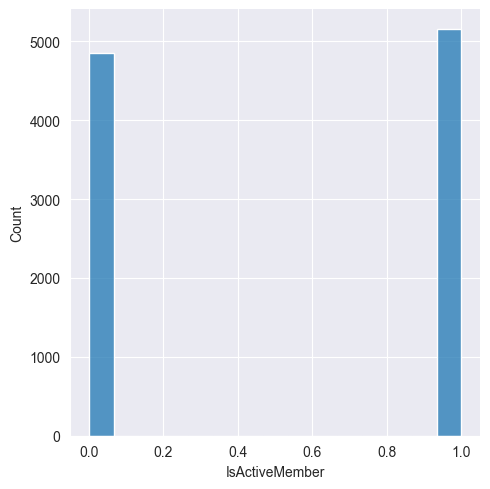

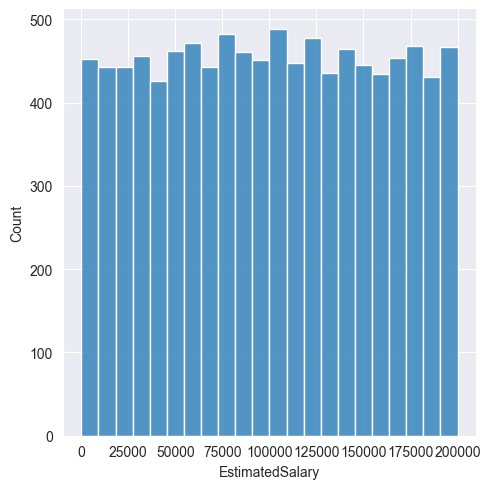

In [15]:
for column in df.select_dtypes(include =['object']).columns:
    if column != 'Exited':
        df[column] = LabelEncoder().fit_transform(df[column])

rows = 2
cols = 5
col=df.columns
index = 0
for i in range(rows):
    for j in range(cols):
        sea.displot(df[col[index]])
        index = index + 1

Now it's time to train the data!

In [16]:
#These next few lines are to set the dependent variable (Exited) and check it is not in the list of x variables.
x = df.drop(columns='Exited')
y = df['Exited']
x.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10


In [17]:
#Splitting, training, and testing the data!
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=40)

I tested a wide range of classification models on this dataset (as you might have seen in my libraries), I am only going to show my best model for the sake of time management on both ends. 


In [18]:
model = RandomForestClassifier().fit(x_train, y_train)
train_pred = model.predict(x_train)

#Next we use metrics to determine the performance of the model.
print('Model accuracy score for training data:', accuracy_score(y_train, train_pred))

test_pred = model.predict(x_test)

print('Model accuracy score for test data:', accuracy_score(y_test, test_pred))

print('-'*50)

print('ROC score for training data:', roc_auc_score(y_train, train_pred))
print('ROC score for test data:', roc_auc_score(y_test, test_pred))

print('-'*50)

print('Confusion matrix for training data:', confusion_matrix(y_train, train_pred))
print('Confusion matrix for test data:', confusion_matrix(y_test, test_pred))

print('-'*50)

print('Kappa Score for training data:', metrics.cohen_kappa_score(y_test, test_pred))

Model accuracy score for training data: 1.0
Model accuracy score for test data: 0.8725
--------------------------------------------------
ROC score for training data: 1.0
ROC score for test data: 0.733485457920792
--------------------------------------------------
Confusion matrix for training data: [[6347    0]
 [   0 1653]]
Confusion matrix for test data: [[1550   66]
 [ 189  195]]
--------------------------------------------------
Kappa Score for training data: 0.5319177056257984


Overall I was happy with the results with the model, 87% accuracy is strong. The majority of the model errors took place in predicting the positive churn portion, this makes sense for the model because before a customer churns they may not show signs of churning. 

To visualize the model a little better I printed out what variables had the largest effect on the model.

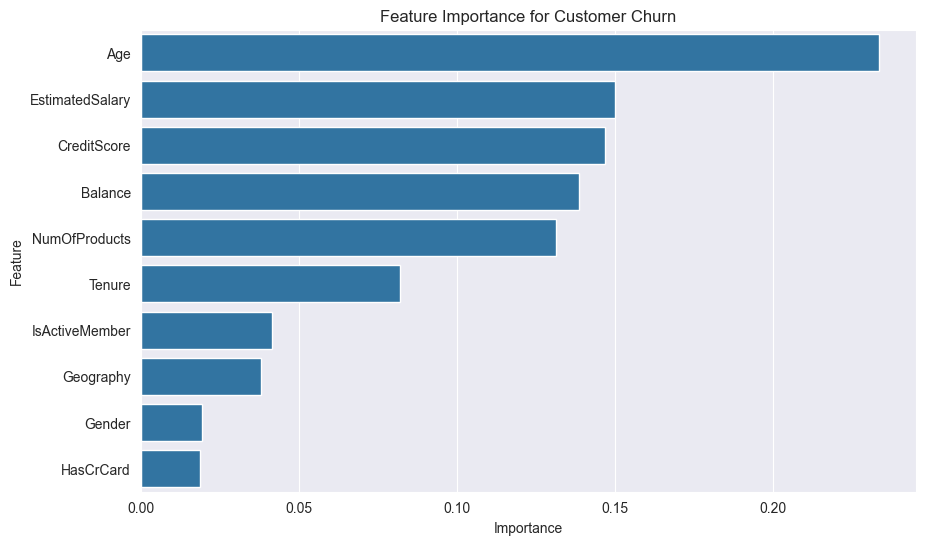

In [19]:
#Here is a feature worth plot to better identify the signs of a customer exiting. 
feature_importances = model.feature_importances_
feature_names = x.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the data by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sea.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Customer Churn')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

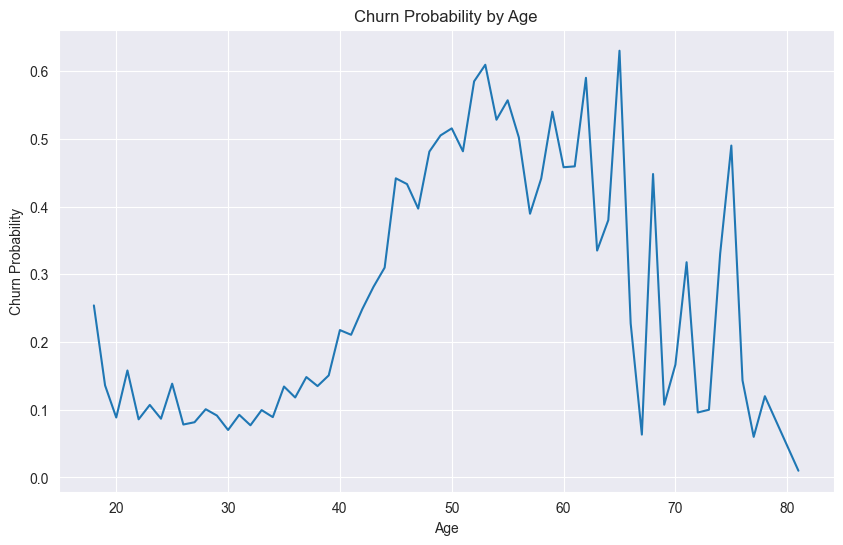

In [20]:
churn_probabilities = model.predict_proba(x_test)[:, 1]  # Get probabilities for the positive class (churn)

# Combine the test set with the predicted probabilities
results_df = x_test.copy()
results_df['churn_probability'] = churn_probabilities
results_df['churn'] = y_test.values  # Add the actual churn values for reference

# Group by age and calculate the mean churn probability for each age
age_churn_probabilities = results_df.groupby('Age')['churn_probability'].mean().reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
sea.lineplot(data=age_churn_probabilities, x='Age', y='churn_probability')
plt.title('Churn Probability by Age')
plt.xlabel('Age')
plt.ylabel('Churn Probability')
plt.show()

For this churn it's projected that when people hit the age of fourty+ they have a much higher chance of churning, so in terms of keeping customers it may be wise to give incentives based off age.

Thanks for viewing!  :)